In [13]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from anomalib.engine import Engine
from torchvision.transforms import ToPILImage
from typing import Any

from anomalib import TaskType
from anomalib.data.image.folder import Folder, FolderDataset
from anomalib.data.utils import InputNormalizationMethod, get_transforms
from anomalib.models import EfficientAd

In [17]:
image_size = (256, 256)
transform = get_transforms(image_size=256, normalization=InputNormalizationMethod.NONE)

In [20]:
# data preparation - a test dataset is provided in the datasets folder
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent / "datasets" / "hazelnut_toy"

folder_datamodule = Folder(
    root=dataset_root,
    normal_dir="good",
    abnormal_dir="crack",
    task=TaskType.SEGMENTATION,
    mask_dir=dataset_root / "mask" / "crack",
    image_size=256,
    normalization=InputNormalizationMethod.NONE,  # don't apply normalization, as we want to visualize the images
)
folder_datamodule.setup()

# folder_dataset_segmentation_test = FolderDataset(
#     normal_dir=dataset_root / "good",
#     abnormal_dir=dataset_root / "crack",
#     split="test",
#     transform=transform,
#     mask_dir=dataset_root / "mask" / "crack",
#     task=TaskType.SEGMENTATION,
# )
# folder_dataset_segmentation_test.setup()  # like the datamodule, the dataset needs to be set up before use
# folder_dataset_segmentation_test.samples.head(10)

In [22]:
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([28, 3, 256, 256])


In [23]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([6, 3, 256, 256]) torch.Size([6, 256, 256])


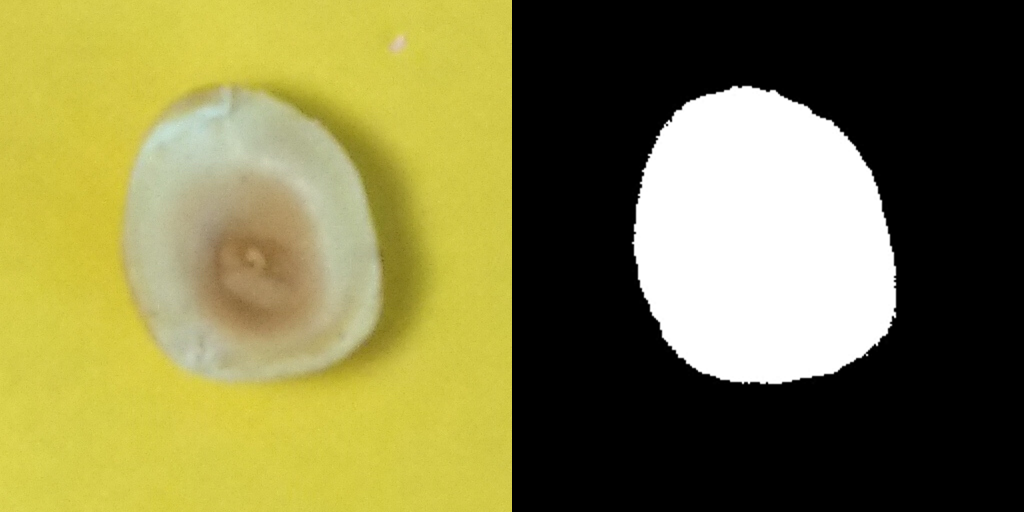

In [24]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

In [25]:
# Get the model
model = EfficientAd()

In [27]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=folder_datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/waynel/anaconda3/envs/anomalib_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/waynel/anaconda3/envs/anomalib_env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/

Training: |          | 0/? [00:00<?, ?it/s]

Calculate teacher channel mean & std:   0%|          | 0/1 [00:14<?, ?it/s]


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.